In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px

import re

from tqdm.notebook import tqdm
import time

In [6]:
import finnhub
finnhub_client = finnhub.Client(api_key="cb5urriad3i0dk7bb5bg")

## Aim of this notebook
#### 1. Get all SP500 companies
#### 2. Get SEC filings for all those companies
#### 3. Store the data in a dataframe

In [7]:
# Getting CIK of the tickers

In [8]:
file = open('Ticker Mapping.txt', 'r')
# Updated BLL to BALL in the ticker mapping file - source = https://www.sec.gov/include/ticker.txt

list_companies = file.readlines()
companies_inSP500 = 505

company_CIK_Mapping = {}
companies_all = []
for i in range(len(list_companies)):
    company_name, company_cik = list_companies[i].split('\t')
    company_cik = company_cik[:-1]

    if( company_name.find('-') != -1):
        company_name = re.sub('-', '.', company_name)
    company_CIK_Mapping[company_name.upper()] = company_cik
    companies_all.append(company_name)
    
print(len(companies_all) == len(set(companies_all)))  ## To check if more than one symbol is present
print(company_CIK_Mapping['AAPL'], company_CIK_Mapping['BBY'], company_CIK_Mapping['WMT'])

True
320193 764478 104169


In [9]:
# Getting list of stocks in SP500

In [10]:
file = open('Companies in SP500.txt', 'r')
list_SP500 = file.readlines()

companies_toStudy_SP500 = []
for i in range(1, companies_inSP500 + 1):
    company_row = list_SP500[i].split('\t') 
    company_ticker = company_row[2]
    
    companies_toStudy_SP500.append(company_ticker)
    
print(companies_toStudy_SP500[0], companies_toStudy_SP500[50], companies_toStudy_SP500[-1])

AAPL MDT EMBC


In [11]:
list_of_CIKS = []

for i in companies_toStudy_SP500:
    list_of_CIKS.append(company_CIK_Mapping[i])
    
print(len(list_of_CIKS))

505


In [130]:
def get_response_fromAPI(CIK, duration):
    try: 
        return finnhub_client.financials_reported(cik = CIK, freq = duration)
    except:
        print("CIK: ", CIK)
        return CIK
    
def add_row_to_list(response, CIK):
    try: 
        row = []
        row.append(response['symbol'])
        row.append(response['year'])
        row.append(response['quarter'])
        row.append(response['form'])
        for k in response['report'].keys():
            for l in response['report'][k]:
                row.append(l['concept'])
                row.append(l['unit'])
                row.append(l['value'])
        return row
    except:
        print("CIK: ", CIK)
        return CIK

In [139]:
count = 0
stocks_dataList = []
failed = []
for i in tqdm(list_of_CIKS[:100]):
    response = get_response_fromAPI(i, 'quarterly')
    if (isinstance(response, str)):
        failed.append(i)
        continue
    for j in response['data']:
        row = add_row_to_list(j, i)
        if (isinstance(row, str)):
            if (i not in failed): 
                failed.append(i)
            continue
        stocks_dataList.append(row)
    time.sleep(2)
    
    response = get_response_fromAPI(i, 'annually')
    if (isinstance(response, str)):
        if (i not in failed): 
            failed.append(i)
        continue
    for j in response['data']:
        row = add_row_to_list(j, i)
        if (isinstance(row, str)):
            if (i not in failed): 
                failed.append(i)
            continue
        stocks_dataList.append(row)
    time.sleep(2)
print(len(failed), failed)

  0%|          | 0/100 [00:00<?, ?it/s]

CIK:  21344
1 ['21344']


In [ ]:
max_params = 0
for i in stocks_dataList:
    max_params = len(i) if len(i) > max_params else max_params

column_list = ['stock', 'year', 'quarter', 'form']
max_params -= 4
max_params //= 3
print(max_params)
for i in range(max_params):
    column_list.append('concept' + str(i))
    column_list.append('unit' + str(i))
    column_list.append('value' + str(i))
print(column_list[:11], len(column_list))

# Adding it to the DF columns
dataFrame = pd.DataFrame(stocks_dataList, columns = column_list)

290
['stock', 'year', 'quarter', 'form', 'concept0', 'unit0', 'value0', 'concept1', 'unit1', 'value1', 'concept2'] 874


In [141]:
dataFrame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4413 entries, 0 to 4412
Columns: 874 entries, 0 to 873
dtypes: float64(139), int64(2), object(733)
memory usage: 29.4+ MB


In [142]:
display(dataFrame.head())
dataFrame.to_csv('DataFromAPI_100Stocks.csv', index = False)

,0,1,2,3,4,5,6,7,8,9,...,864,865,866,867,868,869,870,871,872,873
0,AAPL,2022,2,10-Q,ContractWithCustomerLiabilityCurrent,usd,7920000000,CommonStocksIncludingAdditionalPaidInCapital,usd,61181000000,...,NaN,None,None,NaN,None,None,NaN,None,None,NaN
1,AAPL,2022,1,10-Q,AccumulatedOtherComprehensiveIncomeLossNetOfTax,usd,-927000000,LiabilitiesAndStockholdersEquity,usd,381191000000,...,NaN,None,None,NaN,None,None,NaN,None,None,NaN
2,AAPL,2021,3,10-Q,CommercialPaper,usd,8000000000,InventoryNet,usd,5178000000,...,NaN,None,None,NaN,None,None,NaN,None,None,NaN
3,AAPL,2021,2,10-Q,CashAndCashEquivalentsAtCarryingValue,usd,38466000000,MarketableSecuritiesCurrent,usd,31368000000,...,NaN,None,None,NaN,None,None,NaN,None,None,NaN
4,AAPL,2021,1,10-Q,CashAndCashEquivalentsAtCarryingValue,usd,36010000000,MarketableSecuritiesCurrent,usd,40816000000,...,NaN,None,None,NaN,None,None,NaN,None,None,NaN


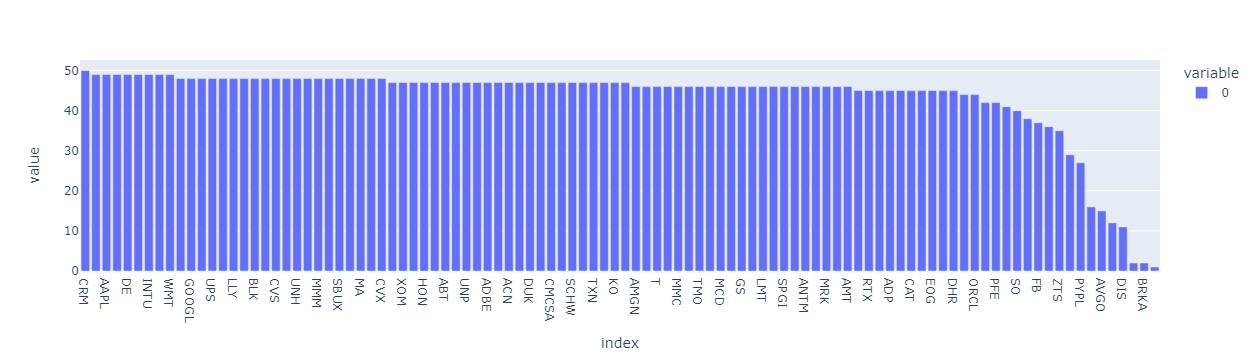

In [143]:
display(px.bar(dataFrame[0].value_counts()))

In [144]:
# print( finnhub_client.financials_reported(symbol = 'BRKA', freq = 'quarterly'))

In [145]:
df = dataFrame.copy()

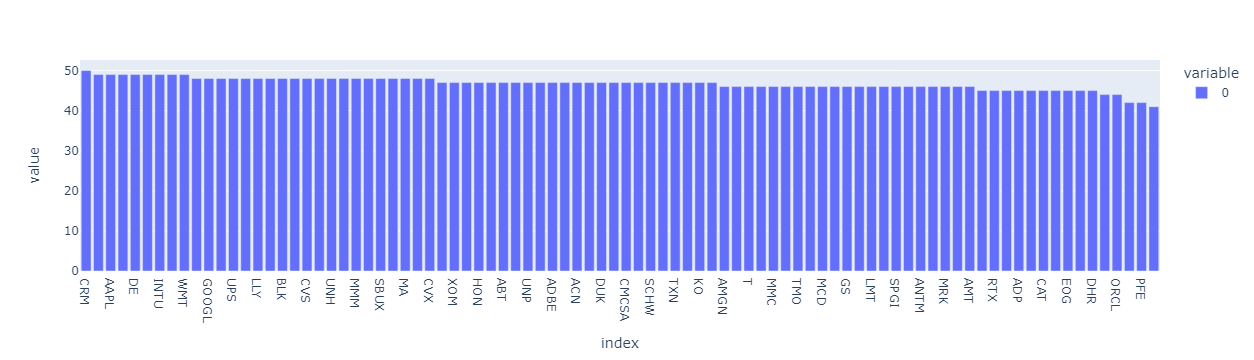

In [146]:
display(px.bar(df[0].value_counts().loc[lambda x : x > 40]))

In [147]:
stocksList_data = df[0].value_counts().loc[lambda x : x > 40].index.to_list()
print(len(stocksList_data), stocksList_data)

88 ['CRM', 'AMAT', 'AAPL', 'LOW', 'DE', 'V', 'INTU', 'NVDA', 'WMT', 'SYK', 'GOOGL', 'ADI', 'UPS', 'NEE', 'LLY', 'NFLX', 'BLK', 'CSCO', 'CVS', 'GILD', 'UNH', 'GE', 'MMM', 'PG', 'SBUX', 'ISRG', 'MA', 'QCOM', 'CVX', 'MS', 'XOM', 'AXP', 'HON', 'PM', 'ABT', 'JNJ', 'UNP', 'JPM', 'ADBE', 'BMY', 'ACN', 'NKE', 'DUK', 'AMD', 'CMCSA', 'HD', 'SCHW', 'BKNG', 'TXN', 'MSFT', 'KO', 'VZ', 'AMGN', 'BAC', 'T', 'MDLZ', 'MMC', 'AMZN', 'TMO', 'CB', 'MCD', 'COST', 'GS', 'INTC', 'LMT', 'PEP', 'SPGI', 'COP', 'ANTM', 'MO', 'MRK', 'C', 'AMT', 'CCI', 'RTX', 'WFC', 'ADP', 'MU', 'CAT', 'IBM', 'EOG', 'PLD', 'DHR', 'TMUS', 'ORCL', 'TSLA', 'PFE', 'BRK-B']


In [148]:
finalDF = dataFrame.loc[dataFrame[0].isin(stocksList_data)]

In [149]:
finalDF[0].value_counts()

CRM      50
V        49
AMAT     49
INTU     49
NVDA     49
         ..
TMUS     44
ORCL     44
TSLA     42
PFE      42
BRK-B    41
Name: 0, Length: 88, dtype: int64

In [150]:
finalDF.head()

,0,1,2,3,4,5,6,7,8,9,...,864,865,866,867,868,869,870,871,872,873
0,AAPL,2022,2,10-Q,ContractWithCustomerLiabilityCurrent,usd,7920000000,CommonStocksIncludingAdditionalPaidInCapital,usd,61181000000,...,NaN,None,None,NaN,None,None,NaN,None,None,NaN
1,AAPL,2022,1,10-Q,AccumulatedOtherComprehensiveIncomeLossNetOfTax,usd,-927000000,LiabilitiesAndStockholdersEquity,usd,381191000000,...,NaN,None,None,NaN,None,None,NaN,None,None,NaN
2,AAPL,2021,3,10-Q,CommercialPaper,usd,8000000000,InventoryNet,usd,5178000000,...,NaN,None,None,NaN,None,None,NaN,None,None,NaN
3,AAPL,2021,2,10-Q,CashAndCashEquivalentsAtCarryingValue,usd,38466000000,MarketableSecuritiesCurrent,usd,31368000000,...,NaN,None,None,NaN,None,None,NaN,None,None,NaN
4,AAPL,2021,1,10-Q,CashAndCashEquivalentsAtCarryingValue,usd,36010000000,MarketableSecuritiesCurrent,usd,40816000000,...,NaN,None,None,NaN,None,None,NaN,None,None,NaN


In [87]:
### Get

{'cik': '320193', 'data': [{'accessNumber': '0000320193-22-000059', 'symbol': 'AAPL', 'cik': '320193', 'year': 2022, 'quarter': 2, 'form': '10-Q', 'startDate': '2021-09-26 00:00:00', 'endDate': '2022-03-26 00:00:00', 'filedDate': '2022-04-29 00:00:00', 'acceptedDate': '2022-04-28 18:03:58', 'report': {'bs': [{'label': 'Deferred revenue', 'concept': 'ContractWithCustomerLiabilityCurrent', 'unit': 'usd', 'value': 7920000000}, {'label': 'Common stock and additional paid-in capital, $0.00001 par value: 50,400,000 shares authorized; 16,207,568 and 16,426,786 shares issued and outstanding, respectively', 'concept': 'CommonStocksIncludingAdditionalPaidInCapital', 'unit': 'usd', 'value': 61181000000}, {'label': 'Total current liabilities', 'concept': 'LiabilitiesCurrent', 'unit': 'usd', 'value': 127508000000}, {'label': 'Other non-current liabilities', 'concept': 'OtherLiabilitiesNoncurrent', 'unit': 'usd', 'value': 52432000000}, {'label': 'Other non-current liabilities', 'concept': 'OtherLiab